In [1]:
import numpy as np
import scipy.sparse as sparse
import scipy
import cvxpy as cp
import matplotlib.pyplot as plt
import dyn_on_U_dagger as api

np.random.seed(0)

In [2]:
# Initialize parameters and SDR constraint
N_omega = 11
omega = np.linspace(-2, 2, N_omega)
N_z = 2
z = np.linspace(0, 4*10**-3, N_z)
delta_z = np.abs(z[1] - z[0])
green_fs = api.get_green_f(omega,z)
projection = np.zeros((N_omega, N_omega))
projections = []
sdr_def_constr = []
sdr_cst = []
for i in range(N_omega):
    for j in range(N_omega):
        proj_copy = projection.copy()
        proj_copy[i, j] = 1
        projections.append(sparse.csc_matrix(proj_copy))
        sdr_def_constr.append(api.sdr_def_constr(N_omega, N_z, sparse.csc_matrix(proj_copy)))
        if i == j:
            sdr_cst.append(2.)
        else:
            sdr_cst.append(0.)

In [3]:
beta_vec = np.exp(-(np.linspace(omega[0], omega[-1], 2*N_omega - 1)**2)/0.2)#np.random.random(2*N_omega - 1)#
beta = scipy.linalg.hankel(beta_vec[:N_omega], beta_vec[N_omega - 1:])
beta_weight = np.sqrt(np.trace(beta.conj().T@beta))
new_beta = beta/beta_weight
delta_k = 1.j*np.diag(omega)
Q_plus = delta_k + beta
Q_minus = delta_k - beta
W_plus = [scipy.linalg.expm(Q_plus*z[i]) for i in range(N_z)]
W_minus = [scipy.linalg.expm(Q_minus*z[i]) for i in range(N_z)]
J = 0.25*(W_plus[-1]@W_plus[-1].conj().T + W_minus[-1]@W_minus[-1].conj().T - 2*np.eye(N_omega))
n = 0.25*np.trace((W_plus[-1] - W_minus[-1]).conj().T@(W_plus[-1] - W_minus[-1]))
W, _, V = scipy.linalg.svd((0.5/np.sqrt(n))*(scipy.linalg.expm((delta_k + beta)*z[-1]) - scipy.linalg.expm((delta_k - beta)*z[-1])))
rand_unitary = W@V
W_plus = [(1/np.sqrt(n))*rand_unitary.conj().T@scipy.linalg.expm(Q_plus*z[i]) for i in range(N_z)]
W_minus = [(1/np.sqrt(n))*rand_unitary.conj().T@scipy.linalg.expm(Q_minus*z[i]) for i in range(N_z)]
X = np.vstack([rand_unitary] + W_plus + W_minus + [beta])
Y = np.vstack([rand_unitary] + W_plus + W_minus + [beta, np.eye(N_omega)])

In [4]:
# Get dynamics constraints
dynamics_mat = []
sympl_mat = []
unit_mat = []
pump_mat = []
prev_photon_nbr = api.photon_nbr_prev_points(N_omega, N_z)
photon_nbr_end = api.photon_nbr_constr(N_omega, N_z, n)
B_U_and_U_ineq = api.ineq_U_and_B_U(N_omega, N_z)
Q_list = api.gen_Q_mat(N_omega, 2000)
unitary_ineq = api.real_ineq_Q(N_omega, N_z, Q_list)
for i in range(len(projections)):
    real_plus, imag_plus, real_minus, imag_minus = api.get_dynamics_sdr(omega, z, n, projections[i])
    unitary_real, unitary_imag = api.unitary_constr(N_omega, N_z, projections[i])
    sympl_real, sympl_imag = api.sympl_constr_sdr(N_omega, N_z, projections[i], n)
    fix_beta_real, fix_beta_imag = api.sdr_fixed_pump(N_omega, N_z, beta, projections[i])
    dynamics_mat += real_plus + imag_plus + real_minus + imag_minus
    sympl_mat += sympl_real + sympl_imag
    unit_mat += [unitary_real] + [unitary_imag]
    pump_mat += [fix_beta_real, fix_beta_imag]
constraints_list = dynamics_mat + sympl_mat  + [photon_nbr_end] + unit_mat + pump_mat

In [5]:
Q_list = api.gen_Q_mat(N_omega, 200) + api.gen_standard_Q_mat(N_omega)
unitary_ineq = api.real_ineq_Q(N_omega, N_z, Q_list)
imag_equal = api.imag_constr_tr_B_U(N_omega, N_z)

In [28]:
np.trace(rand_unitary.conj().T@(W_plus[1] - W_minus[1]))

(0.7423995948424104+3.2243406007807756e-16j)

In [21]:
[0.5*np.real(np.trace(W_plus[1] - W_minus[1]) - np.trace(Q_list[i].conj().T@(W_plus[1] - W_minus[1]))) for i in range(199,len(Q_list))]

[1.7915426508229135,
 0.0,
 1.6892216976849825,
 1.2313697574981566,
 2.270870985603801,
 1.9500227092272022,
 2.1098212120941513,
 2.0847758550367907,
 1.9223764213278716,
 1.5564942839746885,
 1.7919993282778843,
 2.916403894252908,
 2.5508080191587847,
 2.657119729967733,
 2.605055228462306,
 1.841854548501986,
 1.8301960761686062,
 2.4530011055423184,
 1.9586011454764283,
 1.9802496449056624,
 2.2592546783427667,
 2.1778887307755066,
 2.353745900488408,
 2.071070244003444,
 1.789163328079919]

In [19]:
[np.trace(Y.conj().T@unitary_ineq[i]@Y) for i in range(199,len(Q_list))]

[(1.7915426508229175-2.14595797186877e-18j),
 0j,
 (1.689221697684988+0j),
 (1.2313697574981561+1.1917020140109202e-18j),
 (2.270870985603802-1.796186878369714e-18j),
 (1.9500227092272038+6.597577104046002e-19j),
 (2.1098212120941513+8.53568952514398e-19j),
 (2.0847758550367907+1.1657724878435663e-18j),
 (1.9223764213278727+1.264621391256661e-18j),
 (1.5564942839746878+1.0609129054544856e-18j),
 (1.7919993282778826+6.338927224379806e-19j),
 (2.9164038942529116+1.3558177604547046e-18j),
 (2.550808019158782+1.6328100618737882e-18j),
 (2.6571197299677336+1.8715571208075637e-19j),
 (2.6050552284623048+1.3224456587062942e-18j),
 (1.8418545485019848-2.2824115603325004e-18j),
 (1.8301960761686074+1.0266342697326786e-18j),
 (2.4530011055423198+9.274646144388747e-19j),
 (1.9586011454764285+7.185887281535795e-19j),
 (1.9802496449056621+1.62657537212858e-18j),
 (2.2592546783427667+1.764070767076968e-18j),
 (2.1778887307755066+1.349342309596866e-18j),
 (2.353745900488407+1.8268556000678502e-18j),


In [6]:
[np.trace(Y.conj().T@constraints_list[i]@Y) for i in range(len(constraints_list)) if np.abs(np.trace(Y.conj().T@constraints_list[i]@Y)) > 5*10**-6]

[]

In [60]:
[np.trace(Y.conj().T@sdr_def_constr[i]@Y) - sdr_cst[i] for i in range(len(sdr_def_constr)) if np.abs(np.trace(Y.conj().T@sdr_def_constr[i]@Y) - sdr_cst[i]) > 10**-6]

[]

In [61]:
np.trace(Y.conj().T@photon_nbr_end@Y)

(-9.035612535956972e-12+0j)

In [62]:
[np.trace(Y.conj().T@prev_photon_nbr[i]@Y) for i in range(len(prev_photon_nbr))]

[(0.9999999999995811+0j)]

In [63]:
[np.trace(Y.conj().T@unitary_ineq[i]@Y) for i in range(len(unitary_ineq)) if np.trace(Y.conj().T@unitary_ineq[i]@Y) < 0]

[]

In [64]:
np.trace(Y.conj().T@imag_equal@Y)

(2.4070838087248826e-18+0j)

In [65]:
# Objective function
obj_f_mat = api.obj_f(N_omega, N_z)

In [76]:
# Build cvxpy model
variable = cp.Variable(shape=((2*N_z + 3)*N_omega,(2*N_z + 3)*N_omega), hermitian = True)
constraints = [variable >> 0]
constraints += [cp.real(cp.trace(constraints_list[i]@variable)) == 0 for i in range(len(constraints_list))]
constraints += [cp.real(cp.trace(prev_photon_nbr[i]@variable)) >= 0 for i in range(len(prev_photon_nbr))]
constraints += [cp.real(cp.trace(sdr_def_constr[i]@variable)) == sdr_cst[i] for i in range(len(sdr_def_constr))]
constraints += [cp.real(cp.trace(unitary_ineq[i]@variable)) >= 0 for i in range(len(unitary_ineq))]
constraints.append(cp.real(cp.trace(photon_nbr_end@variable)) == 0)
# This constraint make the bound better :D
constraints.append(cp.real(cp.trace(B_U_and_U_ineq@variable)) >= 0)
# Constraint making imaginary part of trace of U_+ - U_- nothing
constraints.append(cp.real(cp.trace(imag_equal@variable)) == 0)
# Maximizing and minimizing dont give the same abs value?
problem = cp.Problem(cp.Minimize(cp.real(cp.trace(obj_f_mat@variable))), constraints)

In [77]:
problem.solve(verbose = True, max_iters = 5*10**5)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 12 03:48:35 PM: Your problem has 5929 variables, 2263 constraints, and 0 parameters.
(CVXPY) Mar 12 03:48:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 12 03:48:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 12 03:48:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 12 03:48:35 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 12 03:48:35 PM: Compiling problem (target solver=SCS).


-1.9442725118755169

In [ ]:
# When putting constraint of 1000 random unitary matrices
print(-1.8849041442466934)
# When putting constraints of 200 random unitary matrices
print(-1.9473086774233224)

In [78]:
a = np.zeros(N_omega)
b = np.zeros(N_omega)
a[-1] = 1
scipy.linalg.hankel(a, b)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [17]:
np.save("fixed_pump_phased_propagators_with_unit_mat_N_omega_21.npy", end_product)

In [68]:
end_product = variable.value

In [21]:
[np.trace(constraints_list[i]@end_product) for i in range(len(constraints_list)) if np.abs(np.trace(Y.conj().T@constraints_list[i]@Y)) > 5*10**-6]

[]

In [69]:
# Get elements of the optimized_result
opt_unit = end_product[:N_omega, (2*N_z + 2)*N_omega:]
opt_B_U_plus_dagger = end_product[:N_omega, (N_z)*N_omega:(N_z + 1)*N_omega]
opt_U_plus_dagger_1 = end_product[N_z*N_omega:(N_z + 1)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_U_plus_dagger_0 = end_product[(N_z - 1)*N_omega:(N_z)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_U_minus_dagger_1 = end_product[2*N_z*N_omega:(2*N_z + 1)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_U_minus_dagger_0 = end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_beta = end_product[(2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]

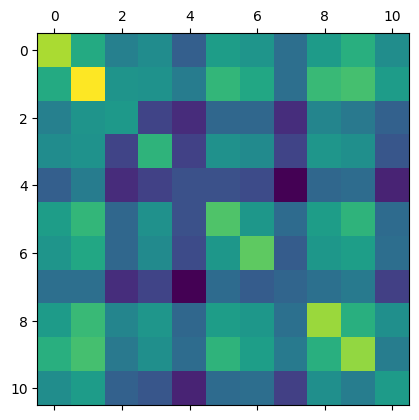

In [71]:
plt.matshow(np.real((n)*end_product[N_omega:2*N_omega, N_omega:2*N_omega] - np.eye(N_omega)))

In [23]:
# The block beta dagger beta is not the same as (Zbeta dagger)dagger (Zbeta)...
(np.real(end_product[(2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega, (2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega]))

array([[10739.11367631,  -625.22640062,  -533.08877664,  -538.61352474,
         -584.89352577,  -568.23748115,  -621.54046267,  -636.00241342,
         -607.94715146,  -661.50873298,  -681.12842448],
       [ -625.22640062, 10677.34017173,  -548.87914215,  -656.9469783 ,
         -547.14317552,  -491.79763669,  -688.81224541,  -657.92226611,
         -661.74856632,  -573.32999039,  -699.92256607],
       [ -533.08877664,  -548.87914215, 10813.22374266,  -641.03793489,
         -701.44514995,  -600.28631166,  -581.57786509,  -557.75956546,
         -618.50342262,  -609.96448558,  -646.61133747],
       [ -538.61352474,  -656.9469783 ,  -641.03793489, 10795.16846176,
         -686.41736512,  -614.97418376,  -558.55717916,  -519.20849979,
         -635.25651208,  -591.2763408 ,  -610.31235862],
       [ -584.89352577,  -547.14317552,  -701.44514995,  -686.41736512,
        10782.11811541,  -560.50959718,  -590.70341969,  -610.77949141,
         -671.37416457,  -581.43321152,  -471.160871

In [24]:
(np.real(opt_beta.conj().T@opt_beta))

array([[1.90124806e+00, 2.08663248e+00, 1.72377371e+00, 1.10288331e+00,
        5.59952853e-01, 2.29406225e-01, 7.65279398e-02, 2.08666918e-02,
        4.65640824e-03, 8.50645239e-04, 1.27213296e-04],
       [2.08663248e+00, 2.57156820e+00, 2.45451197e+00, 1.85910901e+00,
        1.13625658e+00, 5.65469417e-01, 2.30017477e-01, 7.65733414e-02,
        2.08689541e-02, 4.65648529e-03, 8.50643937e-04],
       [1.72377371e+00, 2.45451197e+00, 2.77346474e+00, 2.52878555e+00,
        1.87742464e+00, 1.13928413e+00, 5.65804872e-01, 2.30042386e-01,
        7.65745640e-02, 2.08689520e-02, 4.65640518e-03],
       [1.10288331e+00, 1.85910901e+00, 2.52878555e+00, 2.80078846e+00,
        2.53552350e+00, 1.87853841e+00, 1.13940752e+00, 5.65813927e-01,
        2.30042387e-01, 7.65733406e-02, 2.08666897e-02],
       [5.59952853e-01, 1.13625658e+00, 1.87742464e+00, 2.53552350e+00,
        2.80245002e+00, 2.53579811e+00, 1.87856847e+00, 1.13940752e+00,
        5.65804877e-01, 2.30017479e-01, 7.65279397e-

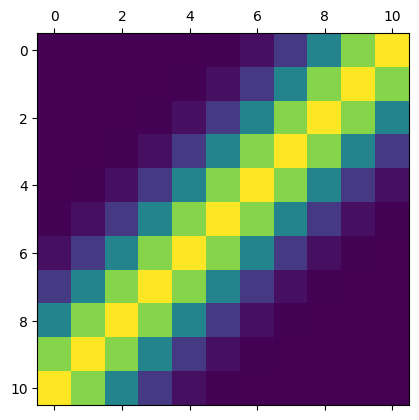

In [73]:
# For free pump, constraints on Hankel form not implemented yet
plt.matshow(np.real(opt_beta))

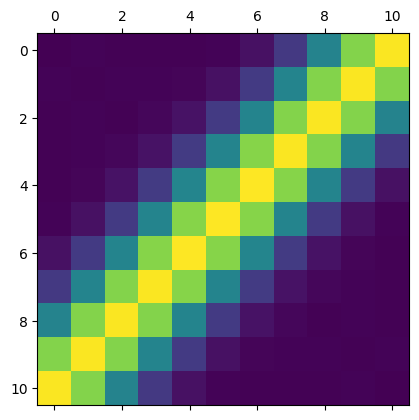

In [90]:
# It reads the exponential relation? When the pump is a diagonal matrix, it does
# Diagonal elements of theoretical U_plus 
# Maximizes the negative of sum of Schimdt number?
plt.matshow((np.real((1/np.sqrt(n))*scipy.linalg.expm((delta_k + opt_beta)*z[-1]))) - np.real((1/np.sqrt(n))*np.eye(N_omega)))

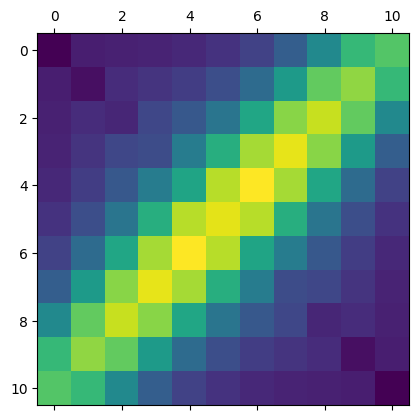

In [106]:
plt.matshow(np.real(opt_U_plus_dagger_1) - np.real((0.0048/np.sqrt(n))*np.eye(N_omega)))

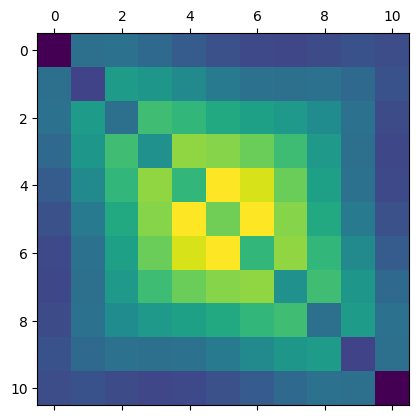

In [78]:
# The B@B_dagger@U_plus from optimization
plt.matshow(np.real(opt_unit@opt_U_plus_dagger_1))

In [4]:
# Theoretical verification of Lippman-Schwinger
proj = (projections[3*N_omega + 3])
test_lin = 0.5*np.trace(proj.conj().T@W_plus[-1].conj().T + proj@W_plus[-1])
green_f_list = api.get_green_f(omega, z)
green_f_list.reverse()
green_f_list[0] = 0.5*green_f_list[0]
green_f_list[-1] = 0.5*green_f_list[-1]
test_quad_normal = 0.5*delta_z*np.trace(sum([W_plus[i].conj().T@proj.conj().T@green_f_list[i].conj().T@beta for i in range(len(W_plus))]))
test_quad_dagger = 0.5*delta_z*np.trace(sum([beta.conj().T@green_f_list[i]@proj@W_plus[i] for i in range(len(W_plus))]))
test_quad = test_quad_normal + test_quad_dagger
test_cst = (1/np.sqrt(n))*np.trace(proj.conj().T@green_f_list[0].conj().T@rand_unitary + green_f_list[0]@proj@rand_unitary.conj().T)

In [5]:
test_lin, test_quad, test_cst, - test_lin + test_quad + test_cst

((-9.892482906639868+0j),
 (0.03195014668389923+0j),
 (-9.924432961011833+0j),
 (9.231193409675598e-08+0j))